In [96]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import datediff, to_date, lit, to_timestamp, col
from pyspark.sql.types import DateType

# Data processing

In [97]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

In [98]:
#read userProfile
userProfile = spark.read.csv("data/users/public_users.csv", header = True)
#filter data on followers_count >= 1 or following_count >= 1
userProfile = userProfile.filter("followers_count >= 1" or "following_count >= 1")
#covert to date 
temp = userProfile.withColumn("record_date",userProfile['created_at'].cast(DateType()))
#get Average daily Tweets
userProfileWithTime = temp.withColumn("days", datediff(to_date(lit("2020-12-12")),'record_date'))
userProfileWithTime = userProfileWithTime.withColumn("dailyTweetsAverage",lit(userProfileWithTime.tweet_count/userProfileWithTime.days))

In [99]:
#process userProfileWithTimePandas data
userProfileWithTimePandas = userProfileWithTime.toPandas()
userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["followers_count"].str.isdigit() == True]
userProfileWithTimePandas["followers_count"] = userProfileWithTimePandas["followers_count"].astype(int)

userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["following_count"].str.isdigit() == True]
userProfileWithTimePandas["following_count"] = userProfileWithTimePandas["following_count"].astype(int)

userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["tweet_count"].str.isdigit() == True]

In [100]:
#read egoTimeline
egoTimeline = spark.read\
       .format("com.databricks.spark.csv")\
       .option("header", "true")\
       .load("data/timelines/public_users_timelines_*.csv")
egoTimeline=egoTimeline.toPandas()
egoTimeline=egoTimeline.rename(columns={'id':'Twitter_id'})

In [101]:
#Friend is defined as a user who has been mentioned at least twice in an ego’s timeline.

egoTimeline=egoTimeline[~(egoTimeline.user_mentions.isnull())]
egoTimeline_of_mentions=egoTimeline.groupby(['user_id','user_mentions']).size().reset_index().rename({0:'number_of_user_mentions'},
                                                                                                     axis=1)
egoTimeline_of_users_and_friends=egoTimeline_of_mentions[egoTimeline_of_mentions.number_of_user_mentions>=2]

In [102]:
#process egoTimeline data
#join with dailyTweetsAverage
egoTimeline_dailyTweetsAverage=egoTimeline_of_users_and_friends.merge(userProfileWithTimePandas[['id','dailyTweetsAverage']],
                                                                    left_on='user_id',right_on='id', how='inner')

egoTimeline_dailyTweetsAverage=egoTimeline_dailyTweetsAverage.drop(['id'],axis=1)

# Plot the graphs

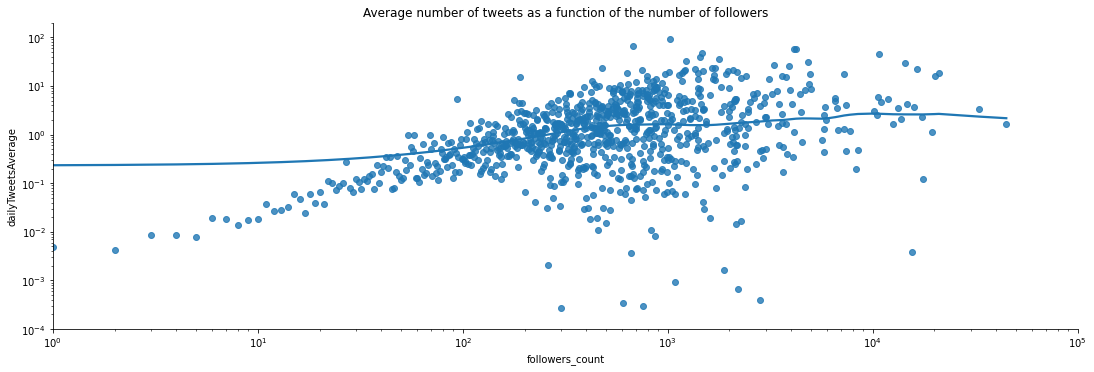

In [103]:
#plot the average number of tweets as a function of the number of followers
followers_count = userProfileWithTimePandas.groupby("followers_count").mean().reset_index()
splot = sns.lmplot(x="followers_count", y="dailyTweetsAverage", data=followers_count,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
plt.ylim(0.0001, 200)
plt.xlim(1, 100000)

plt.title("Average number of tweets as a function of the number of followers")
plt.show()


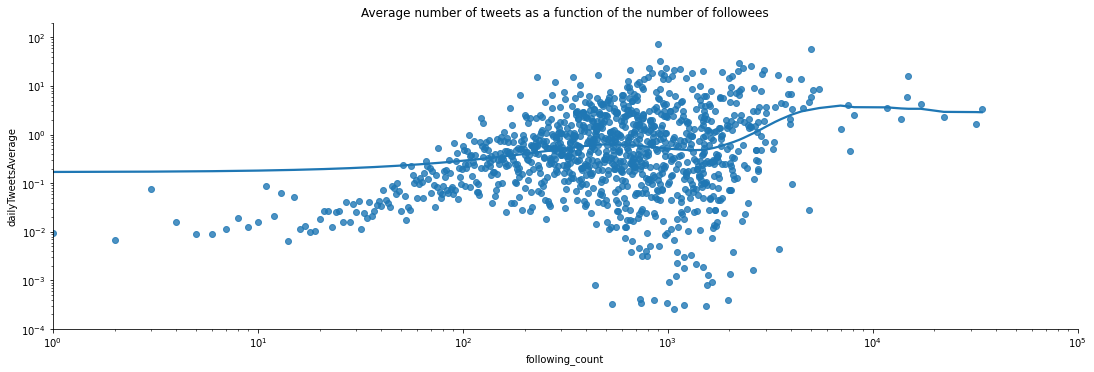

In [104]:
#plot the average number of tweets as a function of the number of followees
following_count = userProfileWithTimePandas.groupby("following_count").mean().reset_index()

splot = sns.lmplot(x="following_count", y="dailyTweetsAverage", data=following_count,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
plt.ylim(0.0001, 200)
plt.xlim(1, 100000)

plt.title("Average number of tweets as a function of the number of followees")

plt.show()


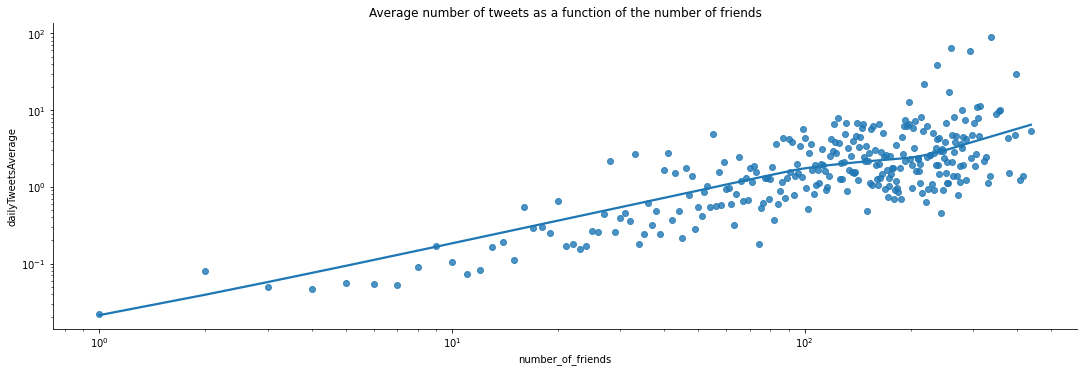

In [105]:
#plot the average number of tweets as a function of the number of friends. 
#Friend here is defined as a user who has been mentioned at least twice in an ego’s timeline.

#count number of friends by user
friends=egoTimeline_dailyTweetsAverage.groupby('user_id').agg({'user_mentions':lambda x: x.count(),
                                                         'dailyTweetsAverage':lambda x: x.mean()}).reset_index()
friends=friends.rename({'user_mentions':'number_of_friends'},axis=1)
friends=friends.groupby('number_of_friends').dailyTweetsAverage.mean().reset_index()
splot = sns.lmplot(x="number_of_friends", y="dailyTweetsAverage", data=friends,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")


plt.title("Average number of tweets as a function of the number of friends")
plt.show()

# Pearson correlation

In [106]:
#The Pearson correlation between number of followers and the average number of tweets and original values of tweet count
userProfileWithTimePandas["tweet_count"]=userProfileWithTimePandas["tweet_count"].astype(int)
userProfileWithTimePandas[['dailyTweetsAverage',
                           'tweet_count',
                           'followers_count',
                          'following_count']].apply(lambda x: np.log(x)).corr( method= 'pearson')


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dailyTweetsAverage,tweet_count,followers_count,following_count
dailyTweetsAverage,1.000000,0.997493,0.749258,0.619394
tweet_count,0.997493,1.000000,0.751906,0.615868
followers_count,0.749258,0.751906,1.000000,0.729187
following_count,0.619394,0.615868,0.729187,1.000000


In [107]:
#get t-statistics and p-value
model_lin = sm.OLS.from_formula("dailyTweetsAverage ~ followers_count", data=userProfileWithTimePandas)
result_lin = model_lin.fit()
result_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     dailyTweetsAverage   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     986.4
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          4.93e-211
Time:                        21:18:38   Log-Likelihood:                -41651.
No. Observations:               18681   AIC:                         8.331e+04
Df Residuals:                   18679   BIC:                         8.332e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2302      0.017     13.882      0.000       0.198       0.263
followers_count     0.0007   2.33e-05     31.406      0.000       0.001       0.001
==============================================================================
Omnibus:                    49581.719   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2295171464.643
Skew:                          31.492   Prob(JB):                         0.00
Kurtosis:                    1719.014   Cond. No.                         719.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
#get t-statistics and p-value
model_lin = sm.OLS.from_formula("dailyTweetsAverage ~ following_count", data=userProfileWithTimePandas)
result_lin = model_lin.fit()
result_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     dailyTweetsAverage   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     493.4
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          6.45e-108
Time:                        21:18:38   Log-Likelihood:                -41888.
No. Observations:               18681   AIC:                         8.378e+04
Df Residuals:                   18679   BIC:                         8.380e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2164      0.017     12.701      0.000       0.183       0.250
following_count     0.0007   3.07e-05     22.213      0.000       0.001       0.001
==============================================================================
Omnibus:                    49317.122   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2101258602.282
Skew:                          31.086   Prob(JB):                         0.00
Kurtosis:                    1644.853   Cond. No.                         567.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
#get t-statistics and p-value
model_lin = sm.OLS.from_formula("TweetsCount ~ followers_count", data=userProfileWithTimePandas)
result_lin = model_lin.fit()
result_lin.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TweetsCount   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 17 Dec 2020   Prob (F-statistic):                nan
Time:                        21:18:38   Log-Likelihood:                    nan
No. Observations:               18681   AIC:                               nan
Df Residuals:                   18679   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept             nan        nan        nan        nan         nan         nan
FollowersCount        nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         4.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
#get t-statistics and p-value
model_lin = sm.OLS.from_formula("TweetsCount ~ following_count", data=userProfileWithTimePandas)
result_lin = model_lin.fit()
result_lin.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TweetsCount   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 17 Dec 2020   Prob (F-statistic):                nan
Time:                        21:18:39   Log-Likelihood:                    nan
No. Observations:               18681   AIC:                               nan
Df Residuals:                   18681   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept              nan        nan        nan        nan         nan         nan
Following_count        nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                          nan
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
#The correlation between number of mentioned users and the average number of tweets
friends[['number_of_friends','dailyTweetsAverage']].apply(lambda x: np.log(x)).corr( method= 'pearson')


,number_of_friends,dailyTweetsAverage
number_of_friends,1.000000,0.762189
dailyTweetsAverage,0.762189,1.000000


In [112]:
#get t-statistics and p-value
model_lin = sm.OLS.from_formula("dailyTweetsAverage ~ number_of_friends", data=friends)
result_lin = model_lin.fit()
result_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     dailyTweetsAverage   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     33.80
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           1.65e-08
Time:                        21:18:39   Log-Likelihood:                -983.06
No. Observations:                 284   AIC:                             1970.
Df Residuals:                     282   BIC:                             1977.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.6917      0.850     -0.814      0.417      -2.365       0.982
number_of_friends     0.0273      0.005      5.814      0.000       0.018       0.036
==============================================================================
Omnibus:                      418.851   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51794.757
Skew:                           7.333   Prob(JB):                         0.00
Kurtosis:                      67.513   Cond. No.                         336.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Conclusion:
In the article: findings are consistent with the previous studies . The Pearson correlation between number of followers and the average number of tweets is 0.70 (t = 181.86, df = 34,004, p < 0.001), while the correlation between number of followees and the average number of tweets is 0.55 (t = 121.24, df = 34,004, p < 0.001), and the correlation between number of mentioned users and the average number of tweets is 0.77 (t = 224.38, df = 34, 004, p < 0.001) (S1 File).

We got:
    The Pearson correlation between number of followers and the average number of tweets is 0.749258 (t = 13.882, df = 18681, p < 0.001), while the correlation between number of followees and the average number of tweets is 0.61939 (t = 12.701 , df = 34,004, p < 0.001), and the correlation between number of mentioned users and the average number of tweets is 0.762189 (t = 224.38, df = 34, 004, p < 0.001) (S1 File).